#### Preamble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# Natal ECG

Text(0, 0.5, 'Maternal respiration')

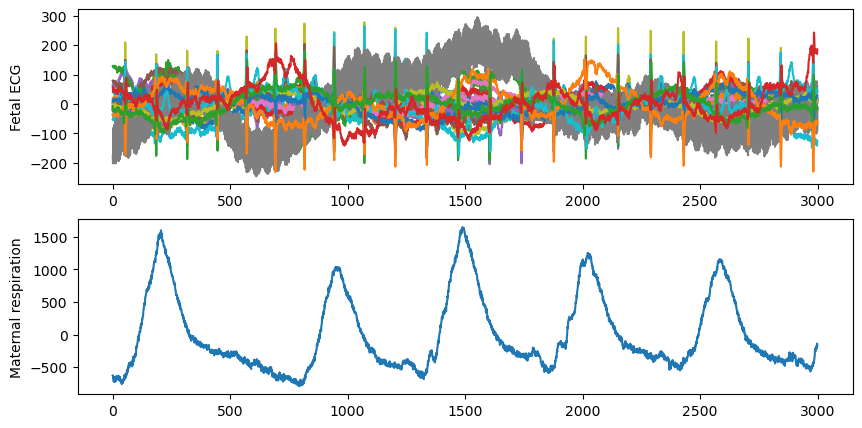

In [9]:
## View and plot data

X_measure = np.load("./benchmarks/data/ecg_data.npy", allow_pickle=True)
y_signal = np.load("./benchmarks/data/ecg_driver.npy", allow_pickle=True)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_measure)
plt.ylabel("Fetal ECG")

plt.subplot(2, 1, 2)
plt.plot(y_signal)
plt.ylabel("Maternal respiration")

Computing distance matrix... Done in 2.00 seconds
Matrix sparsity is:  0.9900002222222222
Computing diffusion components... Done in 0.47 seconds


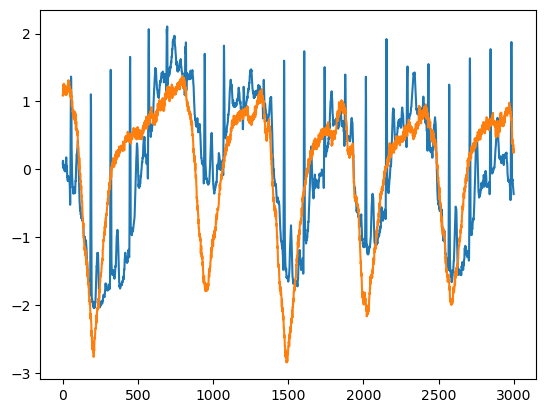

In [10]:
from shrec.models import RecurrenceManifold
from shrec.utils import standardize_ts

model = RecurrenceManifold(random_state=0)
driver_estimate = model.fit_predict(X_measure)

plt.plot(standardize_ts(driver_estimate))
plt.plot(standardize_ts(-y_signal))

# Fluid mixing

Text(0, 0.5, 'Flow control signal')

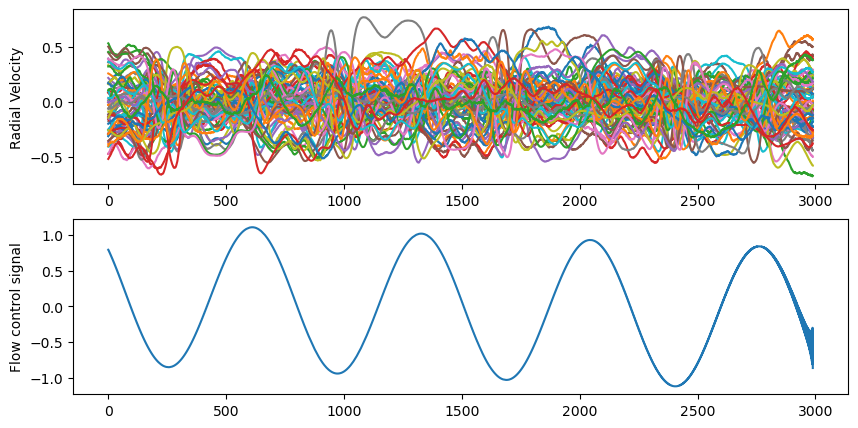

In [16]:
## View and plot data

X_measure = np.load("./benchmarks/data/fluid_data.npy", allow_pickle=True)
y_signal = np.load("./benchmarks/data/fluid_driver.npy", allow_pickle=True)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_measure)
plt.ylabel("Radial Velocity")

plt.subplot(2, 1, 2)
plt.plot(y_signal)
plt.ylabel("Flow control signal")

Computing distance matrix... Done in 5.23 seconds
Matrix sparsity is:  0.9900001118555721
Computing diffusion components... Done in 0.47 seconds


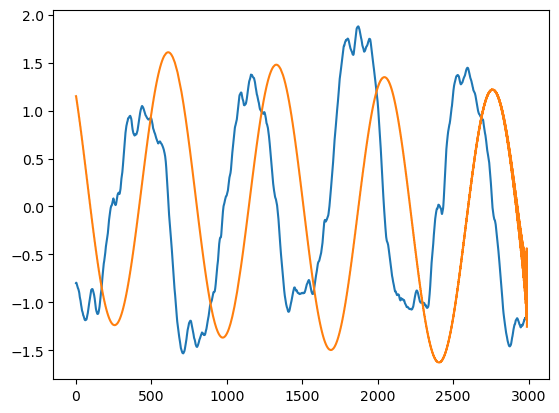

In [17]:
from shrec.models import RecurrenceManifold
from shrec.utils import standardize_ts

model = RecurrenceManifold(random_state=0)
driver_estimate = model.fit_predict(X_measure)

plt.plot(standardize_ts(driver_estimate))
plt.plot(standardize_ts(y_signal))

# Monkey Motor Cortical

Text(0, 0.5, 'Flow control signal')

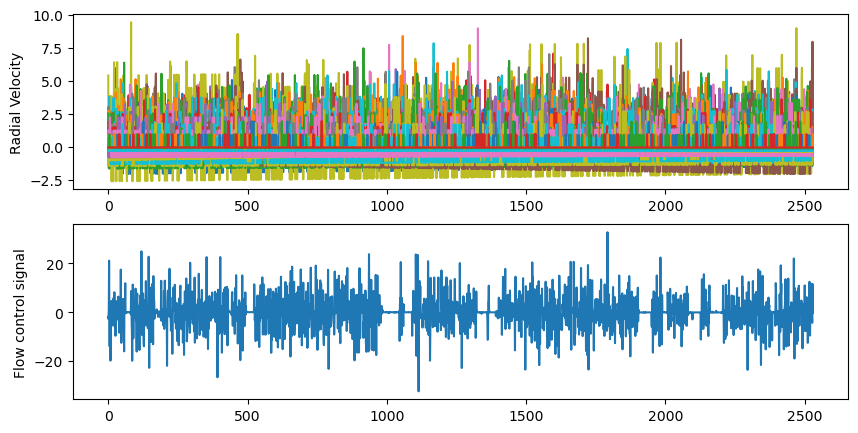

In [18]:
## View and plot data

X_measure = np.load("./benchmarks/data/monkey_data.npy", allow_pickle=True)
y_signal = np.load("./benchmarks/data/monkey_driver.npy", allow_pickle=True)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_measure)
plt.ylabel("Radial Velocity")

plt.subplot(2, 1, 2)
plt.plot(y_signal)
plt.ylabel("Flow control signal")

Computing distance matrix... Done in 9.83 seconds
Matrix sparsity is:  0.9900001562280304
Computing diffusion components... Done in 0.30 seconds


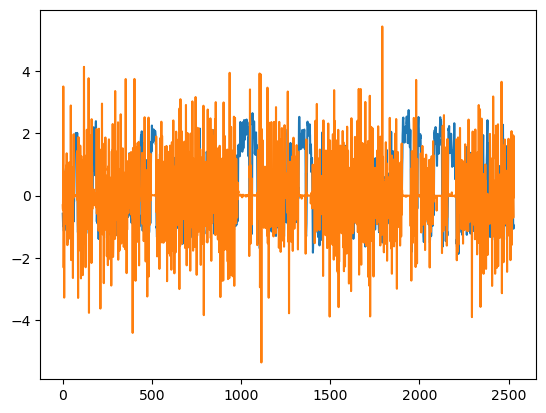

In [19]:
from shrec.models import RecurrenceManifold
from shrec.utils import standardize_ts

model = RecurrenceManifold(random_state=0)
driver_estimate = model.fit_predict(X_measure)

plt.plot(standardize_ts(driver_estimate))
plt.plot(standardize_ts(y_signal))

# Gene expression

Text(0, 0.5, 'Flow control signal')

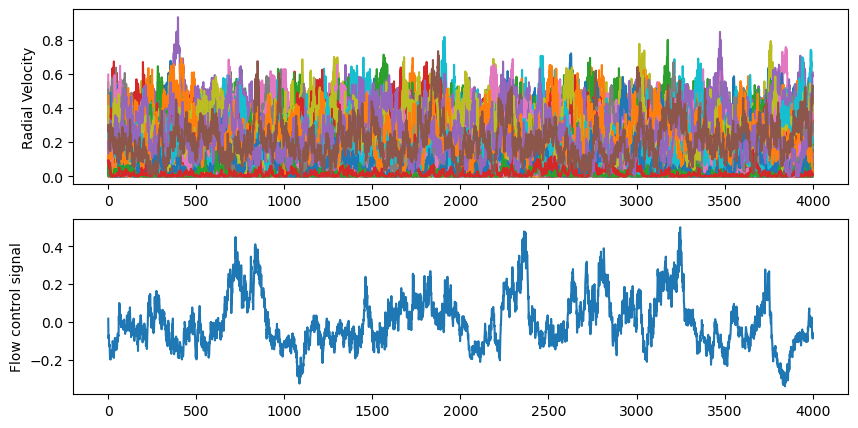

In [20]:
## View and plot data

X_measure = np.load("./benchmarks/data/gene_data.npy", allow_pickle=True)
y_signal = np.load("./benchmarks/data/gene_driver.npy", allow_pickle=True)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(X_measure)
plt.ylabel("Radial Velocity")

plt.subplot(2, 1, 2)
plt.plot(y_signal)
plt.ylabel("Flow control signal")

Computing distance matrix... Done in 13.94 seconds
Matrix sparsity is:  0.9900000024975019
Computing diffusion components... Done in 0.83 seconds


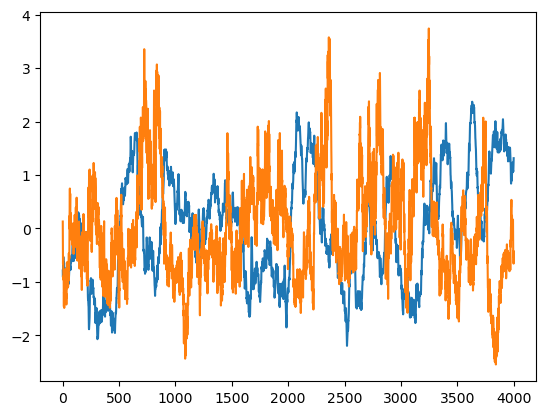

In [21]:
from shrec.models import RecurrenceManifold
from shrec.utils import standardize_ts

model = RecurrenceManifold(random_state=0)
driver_estimate = model.fit_predict(X_measure)

plt.plot(standardize_ts(driver_estimate))
plt.plot(standardize_ts(y_signal))

## Randomly-corrupted measurements driven by an unknown dynamical system

In [ ]:
from scipy.integrate import solve_ivp
from benchmarks.dynamical_systems import DrivenLorenz

eq = DrivenLorenz(random_state=0)
eq.ar =  8 * 20 * 2 * (np.random.random(eq.n_sys)  - 0.5)

ic = np.random.random(3 + 3 * eq.n_sys)
ic[:3] = (1.09189469, -0.44231889,  0.04231979)

tpts0 = np.linspace(0, 100, 5400)
sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

sol = sol0.y.T
tpts = tpts0
# transient_frac = 0.4
# transient_n = int(transient_frac * len(sol))
# sol = sol[transient_n:]
# tpts = tpts0[:-transient_n]

sol_drive, sol_response = sol[:, :3], sol[:, 3:]

# for ensemble
sol_response = np.moveaxis(
    np.reshape(
        sol_response,
        (
            sol_response.shape[0], 
            eq.n_sys, 
            -1
        ),
        order="F"
    ),
    (0, 1, 2), 
    (1, 0, 2)
)
X_measure = sol_response[..., 0]


### Random corruptions
np.random.seed(10)
from scipy.stats import norm
def tuning(x, random_state=None):
    """
    Apply random Gaussian response filters to a measured signal
    """
    n, _ = X_measure.shape
    shifts = 10 * (np.random.random(n) - 0.5)[:, None]
    coeffs = 5 * np.random.random(n)[:, None]
    return norm.pdf((x - shifts) / coeffs)

def standardize_ts(x, axis=-1):
    """
    Standardize time series along a given axis. 
    Clip outliers at 4 standard deviations."""
    # correct for zero-variance time series
    x = x - np.mean(x, axis=axis, keepdims=True)
    scale = np.std(x, axis=axis, keepdims=True)
    scale = np.where(scale == 0, 1, scale)
    x = x / scale
    extremum = np.max(np.abs(x))
    if extremum > 4:
        x = x / extremum
    return x

    
X_measure = tuning(X_measure).T
y_driver = sol_drive[:, 0].T

Text(0.5, 1.0, 'Driving signal and response time series')

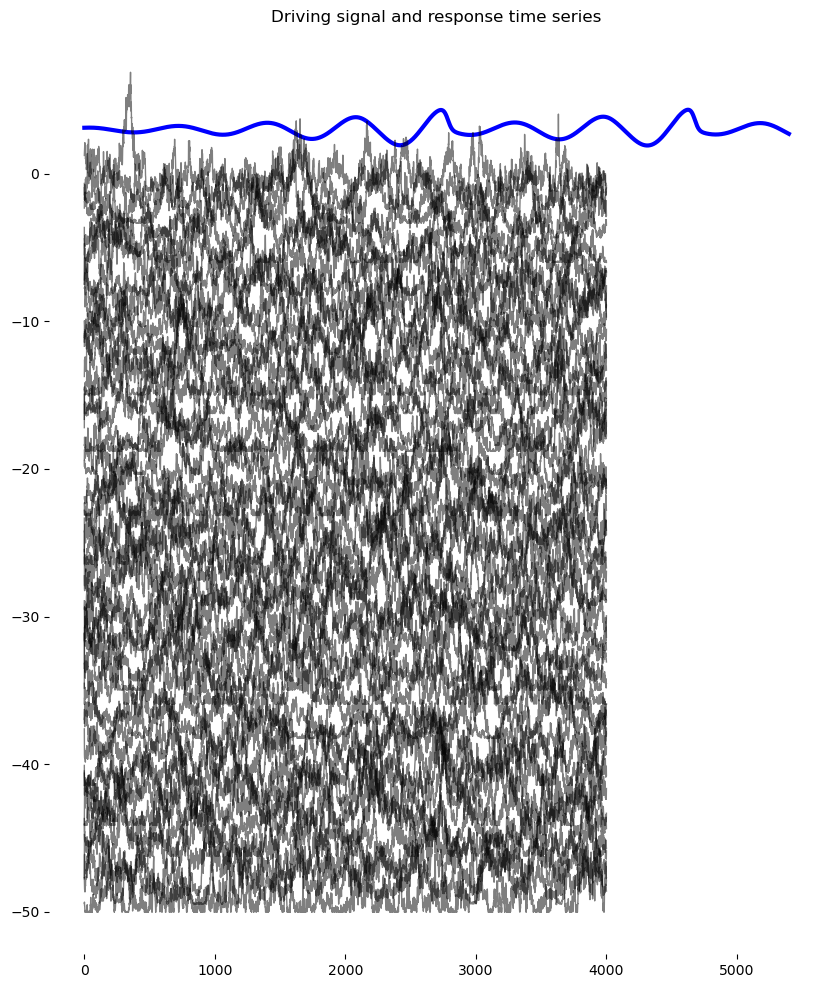

In [22]:
plt.figure(figsize=(10, 12))
plt.plot(3 + 0.5 * standardize_ts(y_driver), linewidth=3, color='b')
# plt.title("True Driver")


for i in range(50):
    plt.plot(-i + standardize_ts(X_measure[:, i]), 'k', linewidth=1, alpha=0.5);

# remove frame and ticks
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# plt.gca().axis('off')
plt.title("Driving signal and response time series")


Computing distance matrix... Done in 13.70 seconds
Matrix sparsity is:  0.9900000024975019
Computing diffusion components... Done in 0.82 seconds


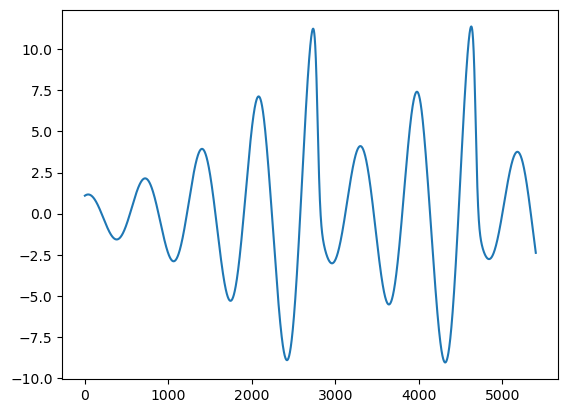

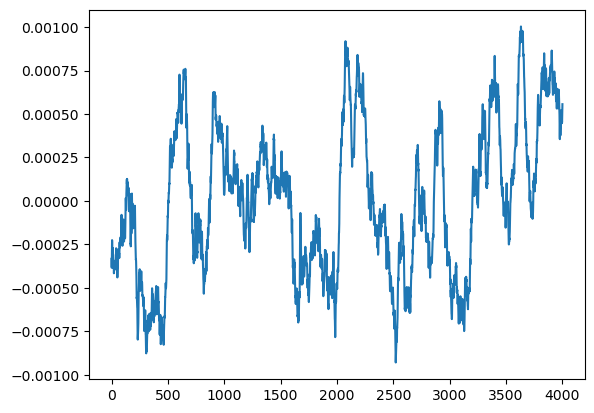

In [23]:
from shrec.models import RecurrenceManifold
model = RecurrenceManifold(random_state=0)
y_reconstructed = model.fit_predict(X_measure)

plt.figure()
plt.plot(y_driver)

plt.figure()
plt.plot(y_reconstructed)